In [358]:
import pandas as pd
import xarray as xr
import numpy as np
from openpiv import tools, process, scaling, validation, filters, preprocess
import os
from time import time
import warnings
import skimage.io as io
import skimage.viewer
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import glob

import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
%matplotlib inline  
from IPython import display
display.set_matplotlib_formats('retina')

### Video Data

In [26]:
#load video

### Distilled Image Frames
Flight 10, 1 second apart, GSD = 0.0952 m/pix

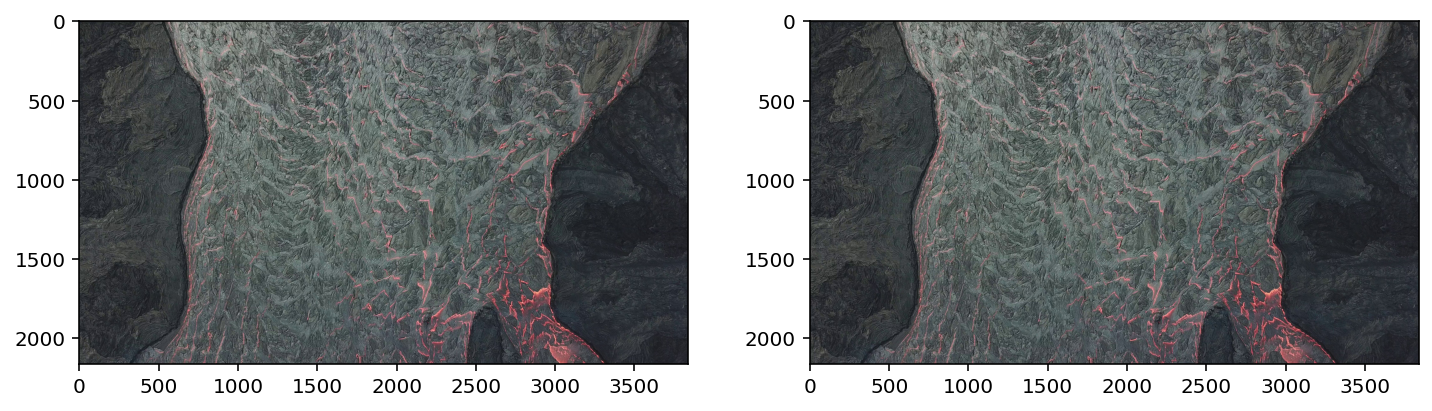

In [2]:
frame_a  = mpimg.imread('/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_116.jpg')
frame_b  = mpimg.imread('/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_117.jpg')

fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a)
ax[1].imshow(frame_b)


In [151]:
frame_a.shape

(2160, 3840, 3)

### Velocity Vector

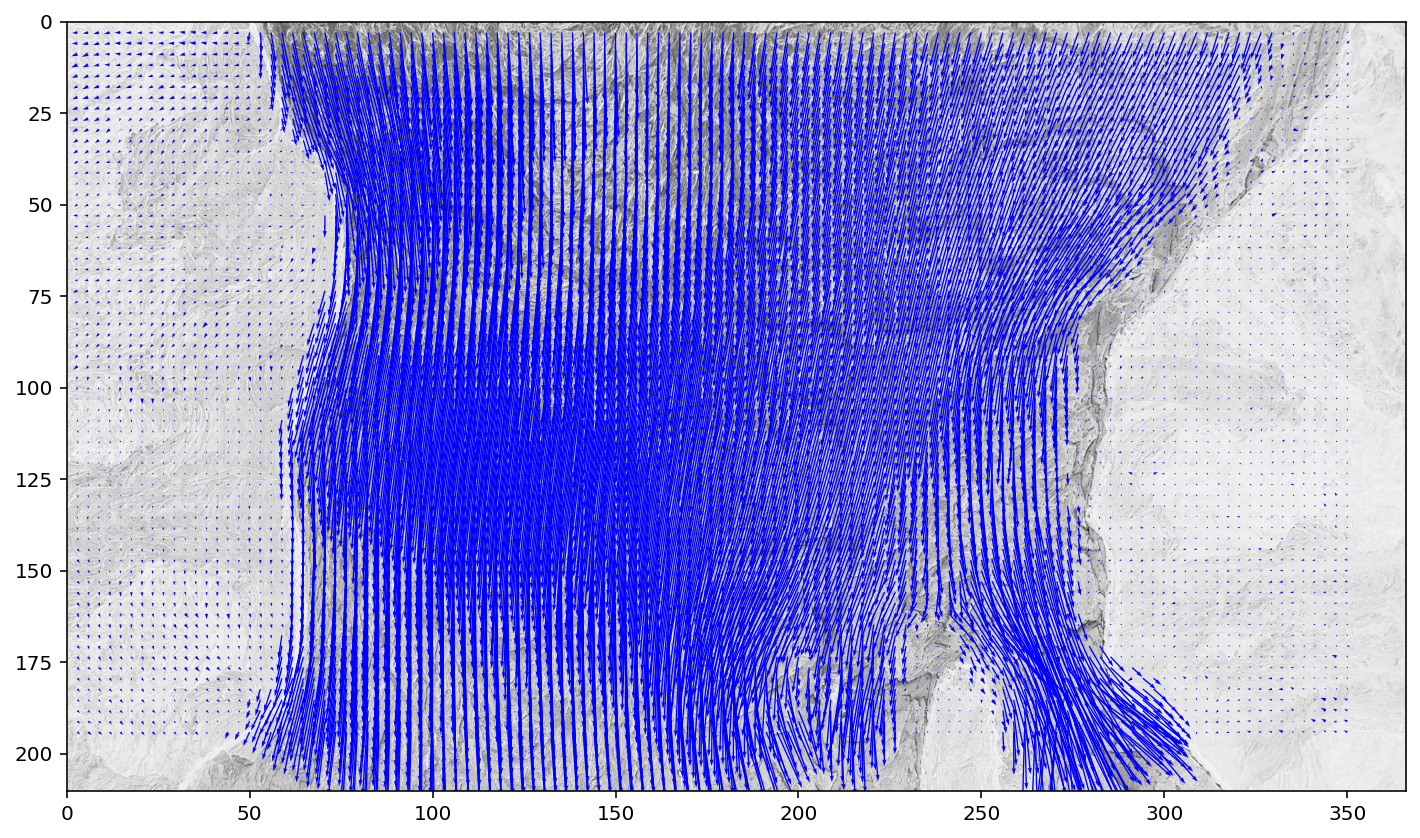

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd4a4a09d00>)

In [58]:
#First veclocity's for Frames 16-17
fig,ax = plt.subplots(figsize=(12,12))
tools.display_vector_field('/Users/Jasper/Volc_Research/OpenPIV/F10_16-17.csv', scale=20, width=0.001,ax=ax,on_img=True,image_name='/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_116.jpg')

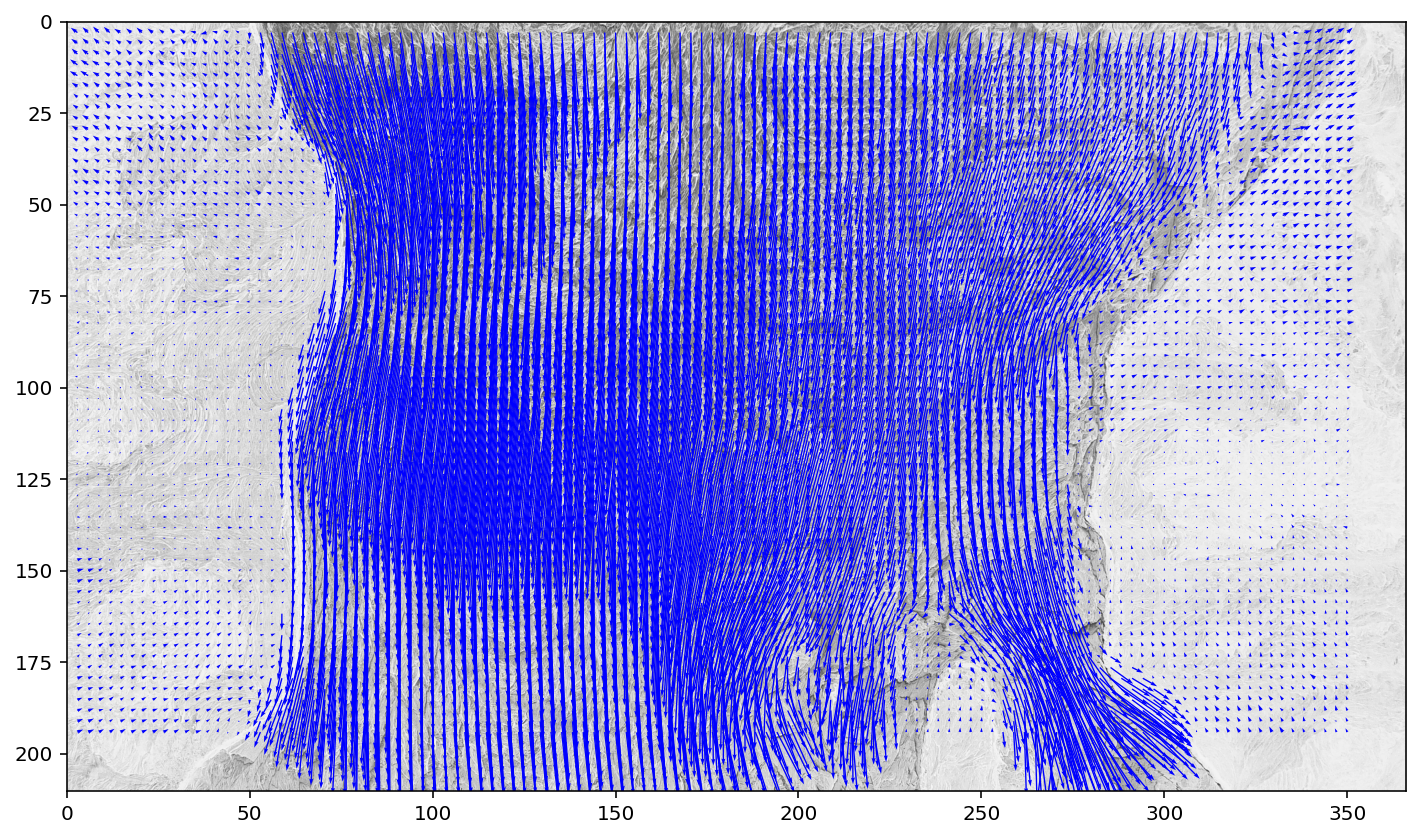

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd4a49f22b0>)

In [60]:
#Second veclocity's for Frames 17-18
fig,ax = plt.subplots(figsize=(12,12))
tools.display_vector_field('/Users/Jasper/Volc_Research/OpenPIV/F10_17-18.csv', scale=20, width=0.001,ax=ax,on_img=True,image_name='/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_117.jpg')

# Loading the Velocity Vectors into DataArrays
pandas to Xarray

In [173]:
files = glob.glob("/Users/Jasper/Volc_Research/OpenPIV/UV_Fields_test/*.csv") #This is the directory witht the CSV files
files



['/Users/Jasper/Volc_Research/OpenPIV/UV_Fields_test/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_16-17.csv',
 '/Users/Jasper/Volc_Research/OpenPIV/UV_Fields_test/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_17-18.csv',
 '/Users/Jasper/Volc_Research/OpenPIV/UV_Fields_test/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_15-16.csv']

In [151]:
#i=0
#for i in range(len(files)):
    df2 = pd.read_csv(files[i], sep = '\t', header=None,index_col=(0,1) )
    df2.columns = ('u', 'v', 'mask')
    df2.index.rename(['x','y'], inplace=True)

    df2 = df2[~df2.index.duplicated()]
    dfx =df2.to_xarray()
    i = i+1 
    

    

In [149]:
dfx

<xarray.Dataset>
Dimensions:  (x: 119, y: 66)
Coordinates:
  * x        (x) float64 32.0 64.0 96.0 128.0 ... 3.744e+03 3.776e+03 3.808e+03
  * y        (y) float64 32.0 64.0 96.0 128.0 ... 2.048e+03 2.08e+03 2.112e+03
Data variables:
    u        (x, y) float64 -0.5868 -0.576 -0.4579 ... -0.4803 -0.4708 -0.5032
    v        (x, y) float64 0.9283 0.8516 1.086 1.086 ... -0.3324 -0.361 -0.367
    mask     (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [111]:
files = glob.glob("/Users/Jasper/Volc_Research/OpenPIV/UV_Fields_test/*.csv") #This is the directory witht the CSV files
files

file1 = files[1]
sec = file1[len(file1)-6: len(file1)-4]
sec
#the string subset may need to be adjusted depeneding on how you saved the file
sec


'18'

### Add time as Dimension

In [139]:
#define time 
time = xr.full_like(dfx.u, sec)
dfx['time']=sec
dfx.coords['time']=time
#dfx.coords['x'] = ('time', dfx.x)

dfx

<xarray.Dataset>
Dimensions:  (x: 119, y: 66)
Coordinates:
  * x        (x) float64 32.0 64.0 96.0 128.0 ... 3.744e+03 3.776e+03 3.808e+03
  * y        (y) float64 32.0 64.0 96.0 128.0 ... 2.048e+03 2.08e+03 2.112e+03
    time     (x, y) float64 18.0 18.0 18.0 18.0 18.0 ... 18.0 18.0 18.0 18.0
Data variables:
    u        (x, y) float64 -1.189 -1.123 -1.042 ... -0.373 -0.3739 -0.3967
    v        (x, y) float64 0.7401 0.6813 0.8476 0.8485 ... 0.6157 0.6067 0.5676
    mask     (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [136]:
 dfx

<xarray.Dataset>
Dimensions:  (time: 119, x: 119, y: 66)
Coordinates:
    x        (time) float64 32.0 64.0 96.0 ... 3.744e+03 3.776e+03 3.808e+03
  * y        (y) float64 32.0 64.0 96.0 128.0 ... 2.048e+03 2.08e+03 2.112e+03
    time     (x, y) float64 18.0 18.0 18.0 18.0 18.0 ... 18.0 18.0 18.0 18.0
Data variables:
    u        (x, y) float64 -1.189 -1.123 -1.042 ... -0.373 -0.3739 -0.3967
    v        (x, y) float64 0.7401 0.6813 0.8476 0.8485 ... 0.6157 0.6067 0.5676
    mask     (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

### Convert pixel/sec to meters/sec and pixels to meters

In [75]:
GSDx =  .0956      #0.0192  #m/pix
GSDy =  .1268      #0.0255  # meters/ pixel

#Velocity Calculation
dfx['u'] = dfx.u *GSDx 
dfx['v'] = dfx.v*-1 * GSDy 

#Spatial Calculation
dfx['x'] = dfx.x*GSDx 
dfx['y'] = dfx.y*GSDy 

### Add Total Velocity (s) to dataArray

In [338]:
s = np.sqrt(dfx.u**2+dfx.v**2)
dfx['s']= s
dfx

<xarray.Dataset>
Dimensions:  (time: 3, x: 119, y: 66)
Coordinates:
  * x        (x) float64 3.059 6.118 9.178 12.24 ... 354.9 357.9 361.0 364.0
  * y        (y) float64 4.058 8.115 12.17 16.23 ... 255.6 259.7 263.7 267.8
  * time     (time) object '16' '17' '18'
Data variables:
    u        (time, x, y) float64 -0.0561 -0.05507 -0.04378 ... -0.08832 -0.0905
    v        (time, x, y) float64 -0.1177 -0.108 -0.1377 ... -0.6348 -0.6299
    mask     (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    s        (time, x, y) float64 0.1304 0.1212 0.1445 ... 0.6421 0.641 0.6364

## Some initial plots

In [318]:
dfx.s.T.plot()
plt.gca().invert_yaxis()
plt.title('Average Speed')
#plt.x_label('meters')

AttributeError: 'Dataset' object has no attribute 's'

Text(0, 0.5, 'y-axis (meters)')

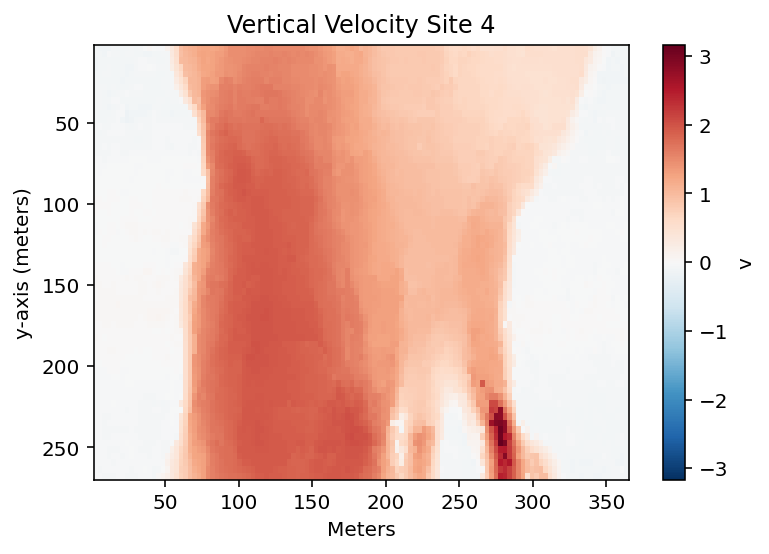

In [187]:
dfx.v.T.plot()
plt.gca().invert_yaxis()
plt.title('Vertical Velocity Site 4')
plt.xlabel('Meters')
plt.ylabel('y-axis (meters)')
#plt.colorbar(lable='m/s')
#SHOULD BE ABOUT 1.33 m/s in the middle of the flow What went wrong?

Text(0.5, 1.0, 'Horizontal Velocity')

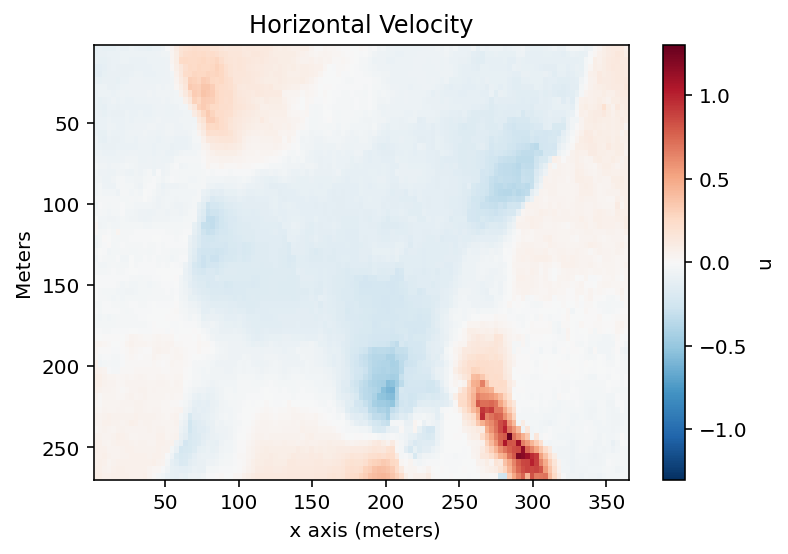

In [188]:
dfx.u.T.plot()
plt.gca().invert_yaxis()
plt.xlabel(' x axis (meters)')
plt.ylabel('Meters')
plt.title('Horizontal Velocity')

In [ ]:
# plot the profile of vertical velocity
plt.plot(dfx.x[0,:],dfx.v[2,:].T)
#plt.plot(dfx.x[0,:],np.ones_like(dfx.x[0,:])*4.3,'--')
plt.show()



In [ ]:
#build xarray with x y as dimensions + coordianted, u v defined at x and y, last dimension of time

In [ ]:
#mask turn into boolean X
#throw away index        X
#load xarray with video, images, velocity fields,
`#temperatue + velocity related

#cross sections -  P colormesh in time
#speed as a function of width - look at tiny branch + compare that to larger one!
#animations -xarray
#spectral changes - fourier (wavelength), power spectral density, spectrograms, look at singe pixel

## Loading Multiple files into one xarray

In [442]:
#Takes multiple CSV files and reads them all into one xarray as a List
files = glob.glob("/Users/Jasper/Volc_Research/OpenPIV/UV_Fields_test/*.csv") #This is the directory witht the CSV files

dfp = []
i=0
for i in range(len(files)):
    dfi = pd.read_csv(files[i], sep = '\t', header=None,index_col=(0,1) )
    dfi.columns = ('u', 'v', 'mask')
    dfi.index.rename(['x','y'], inplace=True)
    dfi = dfi[~dfi.index.duplicated()]
    dfi =dfi.to_xarray()
    file1 = files[i]
    sec = file1[len(file1)-6: len(file1)-4] # may need to be adjusted depending on file name length
    dfi['time']=sec
    dfp.append(dfi)
    i=i+1

In [443]:
dfp # dataArray is in list form

[<xarray.Dataset>
 Dimensions:  (x: 119, y: 66)
 Coordinates:
   * x        (x) float64 32.0 64.0 96.0 128.0 ... 3.744e+03 3.776e+03 3.808e+03
   * y        (y) float64 32.0 64.0 96.0 128.0 ... 2.048e+03 2.08e+03 2.112e+03
 Data variables:
     u        (x, y) float64 -1.429 -1.477 -1.544 -1.583 ... -1.1 -1.194 -1.171
     v        (x, y) float64 0.1809 0.2105 -0.0988 ... 0.4992 0.5393 0.5243
     mask     (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
     time     <U2 '17',
 <xarray.Dataset>
 Dimensions:  (x: 119, y: 66)
 Coordinates:
   * x        (x) float64 32.0 64.0 96.0 128.0 ... 3.744e+03 3.776e+03 3.808e+03
   * y        (y) float64 32.0 64.0 96.0 128.0 ... 2.048e+03 2.08e+03 2.112e+03
 Data variables:
     u        (x, y) float64 -1.739 -1.673 -1.592 ... -0.923 -0.9239 -0.9467
     v        (x, y) float64 5.14 5.081 5.248 5.248 ... 5.02 5.016 5.007 4.968
     mask     (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
     time     <U2 '18'

In [444]:
#Convert it to dataArray and merge coordiantes along time dimension
dfx = xr.concat(dfp, dim = 'time')
dfx =dfx.sortby('time', ascending=True)
dfx

<xarray.Dataset>
Dimensions:  (time: 3, x: 119, y: 66)
Coordinates:
  * x        (x) float64 32.0 64.0 96.0 128.0 ... 3.744e+03 3.776e+03 3.808e+03
  * y        (y) float64 32.0 64.0 96.0 128.0 ... 2.048e+03 2.08e+03 2.112e+03
  * time     (time) object '16' '17' '18'
Data variables:
    u        (time, x, y) float64 -0.5868 -0.576 -0.4579 ... -0.9239 -0.9467
    v        (time, x, y) float64 0.9283 0.8516 1.086 ... 5.016 5.007 4.968
    mask     (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

### Make Conversions to real world units

In [462]:
AGL = 304.8 #meters
FOV = np.deg2rad(78.8) #degrees
Aspect =  2160/3840   #aspect ratio 16:9

D =   2 * AGL *np.tan(FOV/2) #diagnol of image

A = (D) / np.sqrt(1 + Aspect**2)
B = Aspect * D / np.sqrt(1 + Aspect**2)
print('Image Footprint:',A, 'm x', B, 'm')

PixelX = 3840
PixelY = 2180


GSDx = A/ PixelX
GSDy = B/ PixelY

#GSDx =   .08736              #google earth method .0956      #  first method 0.0192 #m/pix
#GSDy =   .1159              #google earth method .1268      # first method 0.0255  # meters/ pixel


print('Ground Sampling Distance:', 'x:', GSDx, 'y:', GSDy)

Image Footprint: 436.4249645610448 m x 245.4890425655877 m
Ground Sampling Distance: x: 0.11365233452110542 y: 0.11260965255302188


In [463]:

#Velocity Calculation
dfx['u'] = dfx.u *GSDx 
dfx['v'] = dfx.v*-1 * GSDy 

#Spatial Calculation
dfx['x'] = dfx.x*GSDx 
dfx['y'] = dfx.y*GSDy 

### Add Total Velocity (s) to dataArray

In [464]:
s = np.sqrt(dfx.u**2+dfx.v**2)
dfx['s']= s
dfx

<xarray.Dataset>
Dimensions:  (time: 3, x: 119, y: 66)
Coordinates:
  * x        (x) float64 3.637 7.274 10.91 14.55 ... 421.9 425.5 429.2 432.8
  * y        (y) float64 3.604 7.207 10.81 14.41 ... 227.0 230.6 234.2 237.8
  * time     (time) object '16' '17' '18'
Data variables:
    u        (time, x, y) float64 -0.06669 -0.06546 -0.05204 ... -0.105 -0.1076
    v        (time, x, y) float64 -0.1045 -0.0959 -0.1223 ... -0.5638 -0.5594
    mask     (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    s        (time, x, y) float64 0.124 0.1161 0.1329 ... 0.5745 0.5735 0.5697

In [ ]:
# just to get array of seconds (not needed, but figure it would be good to hold on to)

#file1 = files[i]
#sec = file1[len(file1)-6: len(file1)-4] # may need to be adjusted depending on file name length
#time = xr.full_like(dfi.u, sec)
#dfi['time']=sec
#dfi.coords['time']=time

## Some Plots with time

Text(0, 0.5, 'meters')

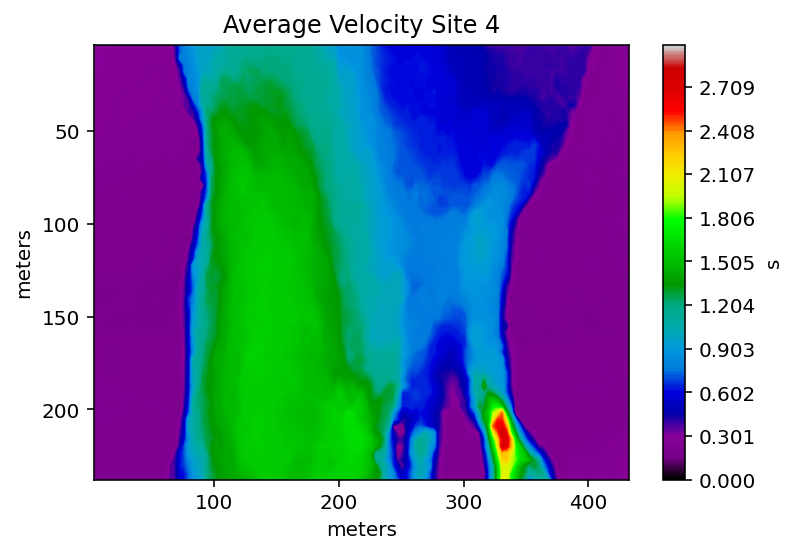

In [465]:
s1 = dfx.s.mean(dim='time').transpose().plot.contourf(levels=300, vmin=0, vmax=3, cmap=cm.nipy_spectral)
plt.gca().invert_yaxis()
plt.title('Average Velocity Site 4')
plt.xlabel('meters')
plt.ylabel('meters')

Text(0, 0.5, 'meters')

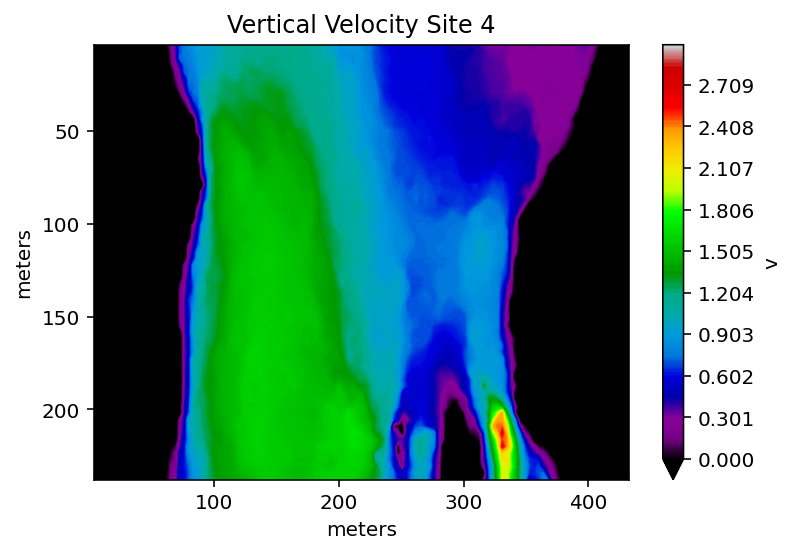

In [466]:
dfx.v.mean(dim='time').transpose().plot.contourf(levels=300, vmin=0, vmax=3, cmap=cm.nipy_spectral)
plt.gca().invert_yaxis()
plt.title('Vertical Velocity Site 4')
plt.xlabel('meters')
plt.ylabel('meters')

Text(0, 0.5, 'meters')

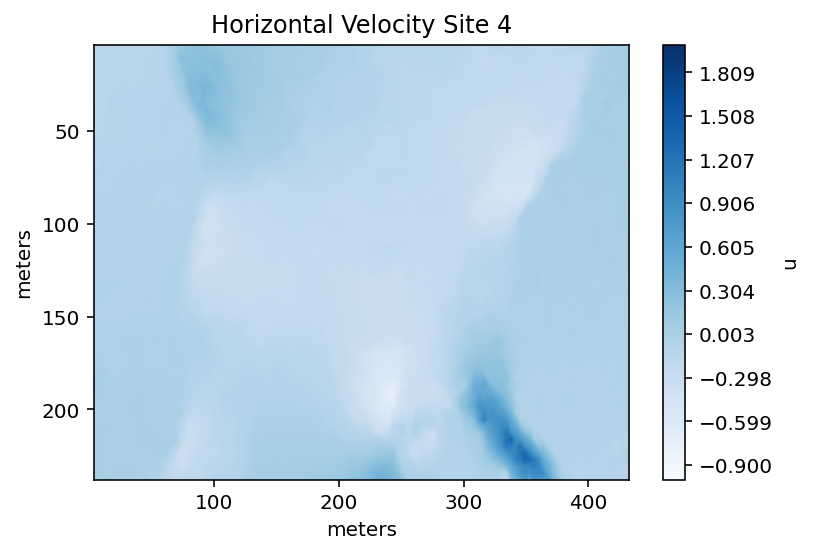

In [477]:
dfx.u.mean(dim='time').transpose().plot.contourf(levels=300, vmin=-1, vmax=2, cmap=cm.Blues)
plt.gca().invert_yaxis()
plt.title('Horizontal Velocity Site 4')
plt.xlabel('meters')
plt.ylabel('meters')

Text(0, 0.5, 'meters')

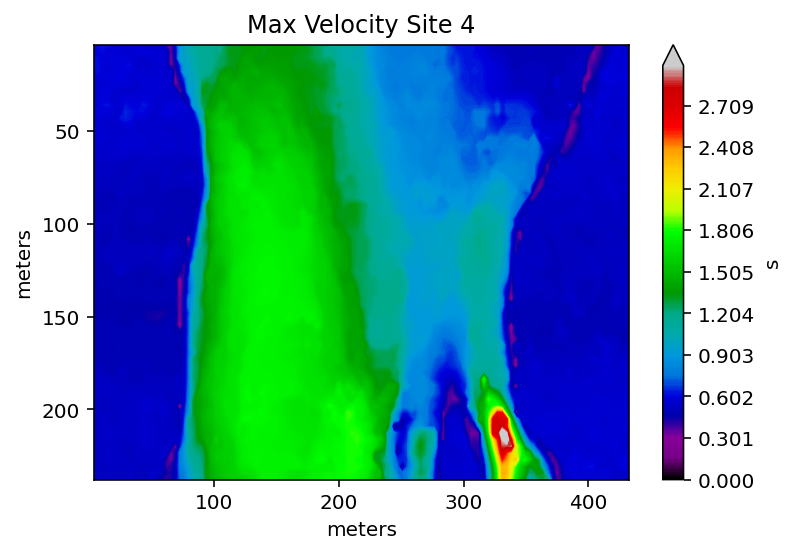

In [479]:
s1 = dfx.s.max(dim='time').transpose().plot.contourf(levels=300, vmin=0, vmax=3, cmap=cm.nipy_spectral)
plt.gca().invert_yaxis()
plt.title('Max Velocity Site 4')
plt.xlabel('meters')
plt.ylabel('meters')

Text(0, 0.5, 'meters')

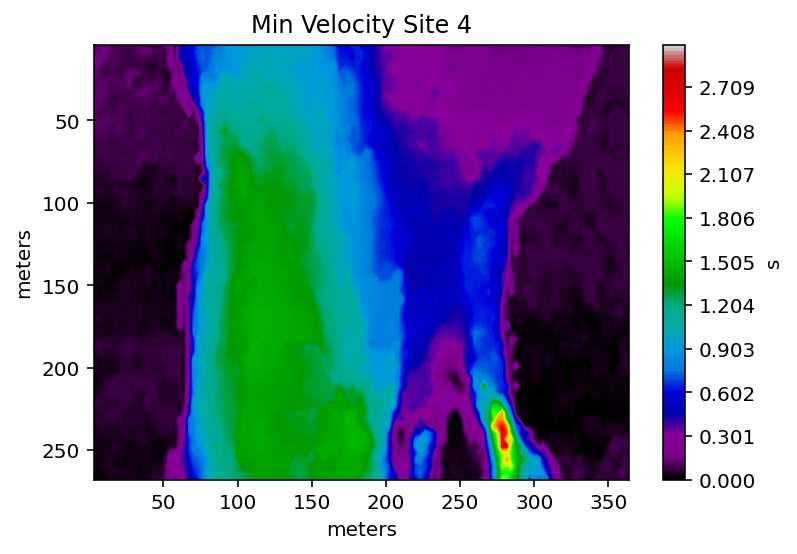

In [427]:
s1 = dfx.s.min(dim='time').transpose().plot.contourf(levels=300, vmin=0, vmax=3, cmap=cm.nipy_spectral)
plt.gca().invert_yaxis()
plt.title('Min Velocity Site 4')
plt.xlabel('meters')
plt.ylabel('meters')

Text(0, 0.5, 'meters')

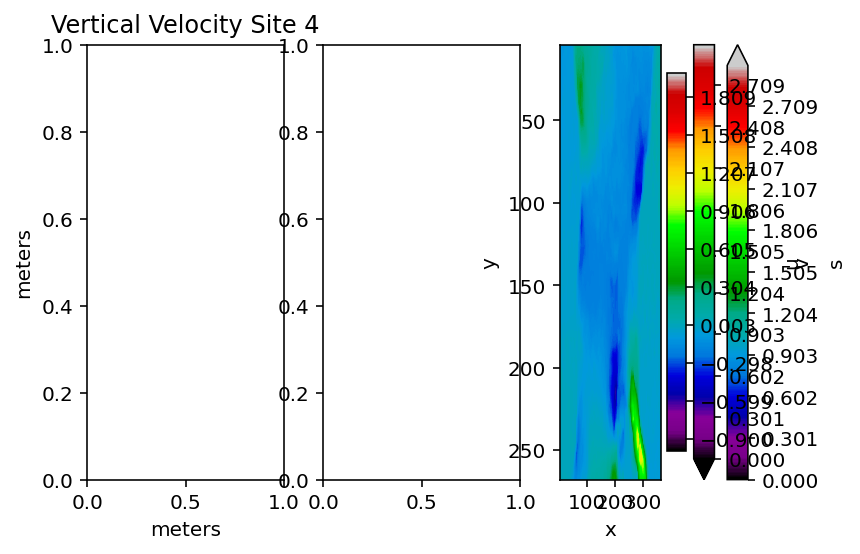

In [421]:
fig, axes = plt.subplots(ncols=3, nrows=1)
ax0, ax1, ax2 = axes
s1 = dfx.s.mean(dim='time').transpose().plot.contourf(levels=300, vmin=0, vmax=3, cmap=cm.nipy_spectral)
v1 = dfx.v.mean(dim='time').transpose().plot.contourf(levels=300, vmin=0, vmax=3, cmap=cm.nipy_spectral)
u1 = dfx.u.mean(dim='time').transpose().plot.contourf(levels=300, vmin=-1, vmax=2, cmap=cm.nipy_spectral)

fig.gca().invert_yaxis()
ax0.set_title('Vertical Velocity Site 4')
ax0.set_xlabel('meters')
ax0.set_ylabel('meters')